In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import readsav
from scipy.interpolate import interp1d
from scipy import optimize
from scipy.optimize import curve_fit
from scipy.signal import savgol_filter
from matplotlib import gridspec

In [5]:
#tube = readsav('dat/f4.sav',verbose=True,python_dict=True)
tube = readsav('/Users/WilliamHenryAshfieldIV/dat/f4_vis5_n400.sav',verbose=False,python_dict=False)
frac = readsav('/Users/WilliamHenryAshfieldIV/dat/f4_vis5_n400_si_iv_nei.sav',verbose=False,python_dict=False)
log10T,log10G = np.loadtxt('/Users/WilliamHenryAshfieldIV/dat/goft_1403.dat.txt',comments='%',unpack=True)

In [6]:
# set inital values
line = 1403.
mass = 28.0*1.66054e-27
kb = 1.3807e-23
c = 300
h = 6.62607e-27
flux=1.0e3 #? why this val?

In [7]:
ll = np.arange(line-10,line+10,0.01)

In [86]:
time= 60 # index = 0.1*time in seconds

In [87]:
t = tube.tarr.t[time]
n = tube.tarr.n[time]
los_v = tube.tarr.v[time].T[0]
sm_v = -los_v
los_x = tube.tarr.x[time].T[0]
n_e = tube.tarr.epamu[time]*tube.tarr.rho[time]/1.67e-8 # number density 
b = tube.tarr.b[time]
dl_e = tube.tarr.dl_e[time]

In [88]:
# interpolate our GofT data
te = 10**log10T
inter = interp1d(te,log10G,kind='cubic', bounds_error=False, fill_value=-10e6) #fill outide vals with large, small number
temp = 1e6*tube.tarr.t[time]
G = inter(temp)

In [89]:
G[temp<22000] = -10000 # set all log10G with low temp to large, small number (st 10^G~0)

In [90]:
f_nei=frac.arrs.f_nei[0]
f_nei = f_nei[:,time]
f_eqi=frac.arrs.f_eqi[0]
f_eqi = f_eqi[:,time]

In [91]:
np.set_printoptions(threshold=100)
jjjs = np.where(G > -5e1)
jjjs

(array([1270, 2721]),)

[ 431  432  433 ... 1808 1809 1810]


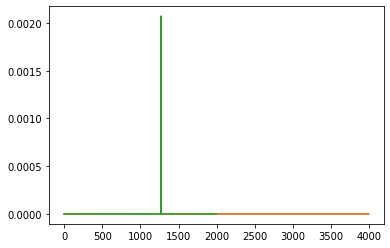

In [92]:
plt.plot(f_eqi)
plt.plot(f_nei)

i_half = int(n/2) #[0:i_half] = left half of tube
test = f_nei[0:i_half]
plt.plot(test)
f_jj = np.where(test > test[0])
f_jj=f_jj[0]
print(f_jj)

In [93]:
temp_fac = f_nei/f_eqi
np.nan_to_num(temp_fac, copy=False, nan=1); # replace inf values with 1 (due to zeros in eqi)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


[1270 1271 1272 ... 1808 1809 1810]


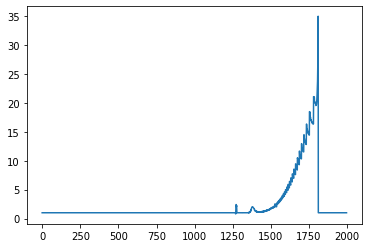

In [94]:
i_half = int(n/2) #[0:i_half] = left half of tube
temp_fac = temp_fac[0:i_half]
plt.plot(temp_fac)
f_jj = np.where(temp_fac > temp_fac[0])
f_jj=f_jj[0]
print(f_jj)

In [95]:
len(f_jj)

493

In [96]:
# define subregion 
i_min,i_max = f_jj[0]-20,f_jj[-1]+20 # left half of tube (start = 3.9s)
print('i_min = ',f_jj[0]-20)
print('i_max = ',f_jj[-1]+20)

t_s = t[i_min:i_max]
n_s = len(t_s)
los_v_s = los_v[i_min:i_max]
sm_v_s = sm_v[i_min:i_max]
los_x_s = los_x[i_min:i_max]
n_e_s = n_e[i_min:i_max]
b_s = b[i_min:i_max]
dl_e_s = dl_e[i_min:i_max]
G_s = G[i_min:i_max]
f_nei_s = f_nei[i_min:i_max]
f_eqi_s = f_eqi[i_min:i_max]

i_min =  1250
i_max =  1830


In [97]:
# interpolate 
N=10*n_s
i_s = np.arange(0,n_s)
ii = np.arange(0,10*(n_s-1))*0.1

int_x = interp1d(i_s,los_x_s,kind='linear')#,fill_value="extrapolate")
int_v = interp1d(i_s,sm_v_s,kind='linear')
int_t = interp1d(i_s,t_s,kind='linear')
int_ne = interp1d(i_s,n_e_s,kind='linear')
int_b = interp1d(i_s,b_s,kind='linear')
int_dl_e = interp1d(i_s,dl_e_s,kind='linear')
int_G = interp1d(i_s,G_s,kind='linear')
int_fnei = interp1d(i_s,f_nei_s,kind='linear')
int_feqi = interp1d(i_s,f_eqi_s,kind='linear')

# new, interpolated arrays from tarr/tube
x = int_x(ii)
v = int_v(ii)
T = int_t(ii)
ne = int_ne(ii)
B = int_b(ii)
Dl = int_dl_e(ii)
g = int_G(ii)
nei = int_fnei(ii)
eqi = int_feqi(ii)

(0, 12)

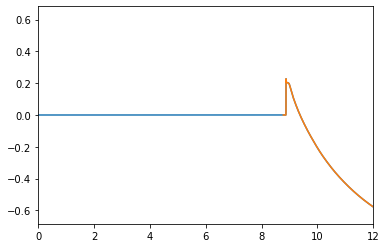

In [99]:
plt.plot(los_x,sm_v)
plt.plot(x,v)
plt.xlim(0,12)
#plt.ylim(0,0.3)

In [23]:
# process to create volume given per flux (per Maxwell)
A = flux/B # replace by area of pixel in Mm (~0.01 Mm^2)
A_pixel = 0.029 # Mm^2 -  pixel area: 0.33 x 0.167 arcsec (as seen on sun..)

volume = Dl*A_pixel*1e24
#calcualte emission measure EM
EM=volume*ne**2

In [24]:
#sig = line*np.sqrt(kb*1e6*T/mass)/(c*1e6) # other thermal width 

# determine line broadening given combination of thermal, non-thermal, and instrumental broadenings
freq = c/line*1e3
v_inst = 3.9 # instrumental broadening (km/s)
sig_inst = v_inst/freq
v_nt = 20.0 # non-thermal broadening (km/s) [De Pontieu et al, 2015]
sig_nt = v_nt/freq
sig_th = line*np.sqrt(kb*1e6*T/mass)/(c*1e6) # thermal broadening (in ˚A)
sig = np.sqrt(sig_th**2+sig_nt**2+sig_inst**2) # total broadening

In [25]:
# calculate prefactor to turn intensity into counts
photo_erg = h*c*1e6/line*1e10 #erg/photon
pixel_size = 12.8e-3 # in ˚A [12.8 m˚A (FUV), 25.6 m˚A (NUV)]
#FOV = 0.33*175*2.35e-11 # in sr 0.33 × 175 arcsec^2 SG-slit
dim = 19e-2
A_iris = 2.2e-4 # effective area FUV
au = 1.49e11
atn = A_iris/au**2
exp_time = 4
#photo_fac = pixel_size*atn*exp_time/photo_erg # converts EM*g/sig (erg/s/sr/˚A) -> photon count
photo_fac = pixel_size*atn*exp_time/photo_erg

In [26]:
factor = nei/eqi
np.nan_to_num(factor, copy=False, nan=1); # replace inf values with 1 (due to zeros in eqi)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


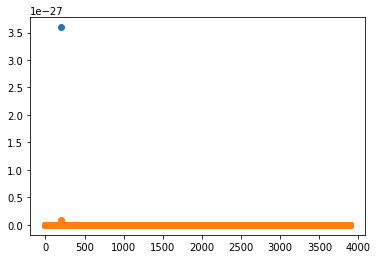

In [27]:
plt.plot(factor*10**g,'o')
plt.plot(10**g,'o')
#plt.xlim(7990,8010)

(180, 210)

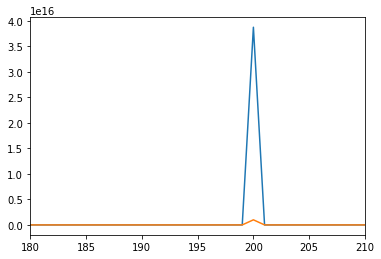

In [28]:
plt.plot(EM*factor*10**g)
plt.plot(EM*10**g)
plt.xlim(180,210)

In [29]:
nn=10*(n_s-1)
print('N = ',nn)
emissNEI = np.empty([nn,len(ll)])
emiss = emissNEI
ii_s = np.zeros(nn)
for i in range(nn):
    
    emissNEI[i,:] = photo_fac*EM[i]*factor[i]*10**g[i]/np.sqrt(2*np.pi)/sig[i]*np.exp(-(ll-line-line*v[i]/c)**2/(2*sig[i]**2))
    
    
    maxi = np.max(emissNEI[i,:])
    if maxi > 0: ii_s[i] = int(i)

ii_s= ii_s[ii_s>0]
ii_s = ii_s.astype(int)
print(ii_s)

N =  3890
[200]


In [34]:
ii_s[-1]

200

In [35]:
tot_emissNEI = np.sum(emissNEI,axis=0)
#tot_emissNEI /= max(tot_emissNEI) #normalize
tot_emiss = np.sum(emiss,axis=0)
#tot_emiss /= max(tot_emiss) #normalize

Text(0.5, 0, 'wavelength [$\\AA$]')

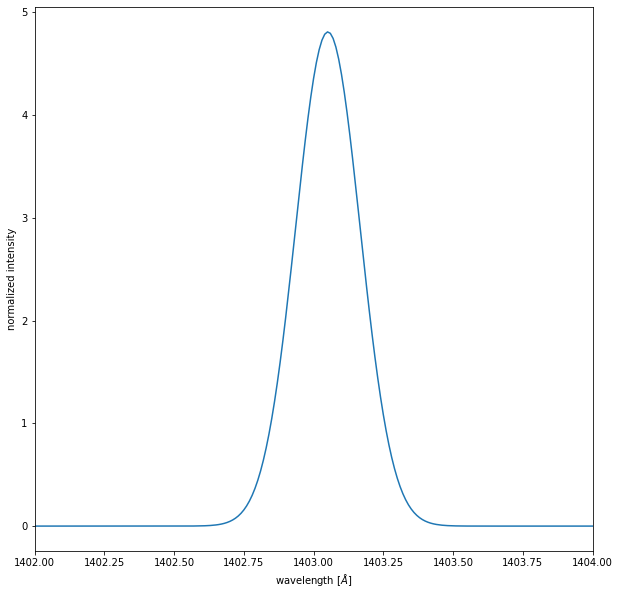

In [36]:
#fig=plt.figure(figsize=[10,10])
fig, ax = plt.subplots(figsize=[10,10])
plt.plot(ll,tot_emissNEI)
#plt.plot(ll,emissNEI[ii_s])
for i in range(ii_s[0],ii_s[-1]):
    plt.plot(ll,emissNEI[i])
    plt.xlim(1402,1404)
plt.xlim(1402,1404)
plt.ylabel('normalized intensity')
ax.set_xlabel('wavelength [$\AA$]')

#fig.savefig('specI.png',bbox_inches='tight', dpi=600)

(0, 5000)

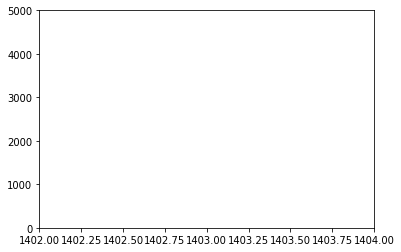

In [32]:
for i in range(ii_s[0],ii_s[-1]):
    plt.plot(ll,emissNEI[i])
    plt.xlim(1402,1404)
plt.xlim(1402,1404)
plt.ylim(0,5000)

In [82]:
np.max(tot_emiss-tot_emissNEI)

0.0

In [ ]:
def oneGauss(x, amp1,cen1,sigma1):
    return amp1*(np.exp((-1.0/2.0)*(((x-cen1)/sigma1)**2)))

In [ ]:
#init params
amp1 = 1
sigma1 = 0.1
cen1 = 1403

In [ ]:
popt_gauss, pcov_gauss = curve_fit(oneGauss, ll, tot_emissNEI, p0=[amp1, cen1, sigma1])
perr_gauss = np.sqrt(np.diag(pcov_gauss))

In [ ]:
print("amplitude = %0.2f (+/-) %0.2f" % (popt_gauss[0], perr_gauss[0]))
print("center = %0.2f (+/-) %0.2f" % (popt_gauss[1], perr_gauss[1]))
print("sigma = %0.2f (+/-) %0.2f" % (popt_gauss[2], perr_gauss[2]))

In [ ]:
#plot
fig = plt.figure(figsize=(14,8))
gs = gridspec.GridSpec(1,1)
ax1 = fig.add_subplot(gs[0])

ax1.plot(ll, tot_emiss)
ax1.plot(ll, oneGauss(ll, *popt_gauss), 'k--')#,\
         #label="y= %0.2f$e^{%0.2fx}$ + %0.2f" % (popt_exponential[0], popt_exponential[1], popt_exponential[2]))

plt.xlim(1402,1406)

ax1.set_xlabel("wavelength",  fontsize=12)
ax1.set_ylabel("intensity",  fontsize=12)


fig.tight_layout()

In [ ]:
def twoGauss(x, amp1,cen1,sigma1, amp2,cen2,sigma2):
    return amp1*(np.exp((-1.0/2.0)*(((x-cen1)/sigma1)**2))) + \
            amp2*(np.exp((-1.0/2.0)*(((x-cen2)/sigma2)**2)))

In [ ]:
amp2 = 0.6
sigma2 = 0.01
cen2 = 1404
popt_2gauss, pcov_2gauss = curve_fit(twoGauss, ll, tot_emiss, \
                                                    p0=[amp1, cen1, sigma1, amp2, cen2, sigma2], maxfev=4000)
perr_2gauss = np.sqrt(np.diag(pcov_2gauss))
print("amplitude = %0.2f (+/-) %0.2f" % (popt_2gauss[0], perr_2gauss[0]))
print("center = %0.2f (+/-) %0.2f" % (popt_2gauss[1], perr_2gauss[1]))
print("sigma = %0.2f (+/-) %0.2f" % (popt_2gauss[2], perr_2gauss[2]))
print("amplitude = %0.2f (+/-) %0.2f" % (popt_2gauss[3], perr_2gauss[3]))
print("center = %0.2f (+/-) %0.2f" % (popt_2gauss[4], perr_2gauss[4]))
print("sigma = %0.2f (+/-) %0.2f" % (popt_2gauss[5], perr_2gauss[5]))

pars_1 = popt_2gauss[0:3]
pars_2 = popt_2gauss[3:6]
gauss_peak_1 = oneGauss(ll, *pars_1)
gauss_peak_2 = oneGauss(ll, *pars_2)
residual_2gauss = tot_emiss - (twoGauss(ll, *popt_2gauss))


#plot
fig = plt.figure(figsize=(14,8))
gs = gridspec.GridSpec(2,1, height_ratios=[1,0.25])
ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1])
gs.update(hspace=0) 

ax1.plot(ll, tot_emiss)
ax1.plot(ll, twoGauss(ll, *popt_2gauss), 'k--')#,\
         #label="y= %0.2f$e^{%0.2fx}$ + %0.2f" % (popt_exponential[0], popt_exponential[1], popt_exponential[2]))

# peak 1
ax1.plot(ll, gauss_peak_1, "g")
ax1.fill_between(ll, gauss_peak_1.min(), gauss_peak_1, facecolor="green", alpha=0.5)
  
# peak 2
ax1.plot(ll, gauss_peak_2, "y")
ax1.fill_between(ll, gauss_peak_2.min(), gauss_peak_2, facecolor="yellow", alpha=0.5)  
ax1.get_xaxis().set_visible(False)

# residual
ax2.plot(ll, residual_2gauss, "b")
    
ax1.set_xlim(1403,1404.5)
ax2.set_xlim(1403,1404.5)

ax2.set_xlabel("wavelength")
ax1.set_ylabel("intensity")
ax2.set_ylabel("res.")

fig.tight_layout()
#fig.savefig("fit2Gaussian_peaks_resid.png", format="png",dpi=1000)

In [ ]:
# trim excess zeros in data
jj = np.where((ll > 1403) & (ll < 1405))
ll = ll[jj]
tot_emiss = tot_emiss[jj]

y_model = twoGauss(ll, *popt_2gauss)
y = tot_emiss
error = 0.001

chi2 = ((y_model - y) / error)**2

x2=np.sum(chi2)

rx2 = x2/(len(tot_emiss)-6)
print(rx2)

In [ ]:
# single Gaussian
y_model=oneGauss(ll, *popt_gauss)
chi2 = ((y_model - y) / error)**2
x2=np.sum(chi2)
rx2 = x2/(len(tot_emiss)-3)
print(rx2)

In [ ]:
def threeGauss(x, amp1,cen1,sigma1, amp2,cen2,sigma2,amp3,cen3,sigma3):
    return amp1*(np.exp((-1.0/2.0)*(((x-cen1)/sigma1)**2))) + \
            amp2*(np.exp((-1.0/2.0)*(((x-cen2)/sigma2)**2))) + \
            amp3*(np.exp((-1.0/2.0)*(((x-cen3)/sigma3)**2)))

In [ ]:
amp3 = 0.5
sigma3 = 0.01
cen3 = 1403.5
popt_3gauss, pcov_3gauss = curve_fit(threeGauss, ll, tot_emiss, \
                                    p0=[amp1, cen1, sigma1, amp2, cen2, sigma2,amp3,cen3,sigma3], maxfev=4000)
perr_3gauss = np.sqrt(np.diag(pcov_2gauss))

pars_1 = popt_3gauss[0:3]
pars_2 = popt_3gauss[3:6]
pars_3 = popt_3gauss[6:9]
gauss_peak_1 = oneGauss(ll, *pars_1)
gauss_peak_2 = oneGauss(ll, *pars_2)
gauss_peak_3 = oneGauss(ll, *pars_3)
residual_3gauss = tot_emiss - (threeGauss(ll, *popt_3gauss))


#plot
fig = plt.figure(figsize=(14,8))
gs = gridspec.GridSpec(2,1, height_ratios=[1,0.25])
ax1 = fig.add_subplot(gs[0])
ax2 = fig.add_subplot(gs[1])
gs.update(hspace=0) 

ax1.plot(ll, tot_emiss)
ax1.plot(ll, threeGauss(ll, *popt_3gauss), 'k--')#,\
         #label="y= %0.2f$e^{%0.2fx}$ + %0.2f" % (popt_exponential[0], popt_exponential[1], popt_exponential[2]))

# peak 1
ax1.plot(ll, gauss_peak_1, "g")
ax1.fill_between(ll, gauss_peak_1.min(), gauss_peak_1, facecolor="green", alpha=0.5)
  
# peak 2
ax1.plot(ll, gauss_peak_2, "y")
ax1.fill_between(ll, gauss_peak_2.min(), gauss_peak_2, facecolor="yellow", alpha=0.5)  

# peak 3
ax1.plot(ll, gauss_peak_3, "m")
ax1.fill_between(ll, gauss_peak_2.min(), gauss_peak_3, facecolor="yellow", alpha=0.5)  
ax1.get_xaxis().set_visible(False)

# residual
ax2.plot(ll, residual_3gauss, "b")
    
ax1.set_xlim(1403,1404.5)
ax2.set_xlim(1403,1404.5)

ax2.set_xlabel("wavelength")
ax1.set_ylabel("intensity")
ax2.set_ylabel("res.")

fig.tight_layout()
#fig.savefig("fit2Gaussian_peaks_resid.png", format="png",dpi=1000)

In [ ]:
# triple Gaussian
y_model=threeGauss(ll, *popt_3gauss)
chi2 = ((y_model - y) / error)**2
x2=np.sum(chi2)
rx2 = x2/(len(tot_emiss)-6)
print(rx2)

In [ ]:
perr_3gauss

In [ ]:
(1403.88 -line)/line*3e5